Strategia inwestycyjna (decyzje wejścia i wyjścia) dla spółki  Microsoft (MSFT), 

test w okresie od 01.01.2024 - 06.05.2024



Stwórz model generujący sygnały kupna i sprzedaży na rynku

Decyzje ma generować jeden z algorytmów uczenia maszynowego, po optymalizacji hiperparametrów

Zrób backtest wybranego modelu, użyj biblioteki przystosowanej do backtestów

Pamiętaj o wnioskach i wizualizacji wyników

4 pkt z oceny będą zależne od wyników inwestycji

Inwestujesz w wylosowaną spółkę przez określony okres, ale można wykorzystać także inne dane niż historyczne (np. obliczone wskaźniki)


In [2]:
import ffn # http://pmorissette.github.io/ffn/index.html

import yfinance as yf
import datetime as dt

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox

from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting import *

import simpful as sf
from simpful import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


Loading BokehJS ...

#### Pobranie szeregu czasowego

In [3]:
start_date = dt.datetime(2019,1,1) # (RRR-MM-DD)
end_date = dt.datetime(2024,5,6)

#loading from yahoo finance
data = yf.download("AMZN",start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,1344.00,1344.00,1344.00,1344.00,1344.00,1.344000e+03
mean,130.45,132.03,128.79,130.43,130.43,7.375730e+07
std,32.23,32.50,31.87,32.14,32.14,3.354315e+07
min,73.26,76.90,73.05,75.01,75.01,1.762600e+07
25%,96.65,97.74,95.34,96.61,96.61,5.150150e+07
50%,130.96,132.41,128.95,130.57,130.57,6.434465e+07
75%,160.23,161.81,158.34,160.16,160.16,8.687058e+07
max,187.72,189.77,185.51,189.05,189.05,3.113460e+08


Spółka wypłacała dywidendę, jednak do stworzenia i testowania strategii nie będę używać danych po korekcie.  

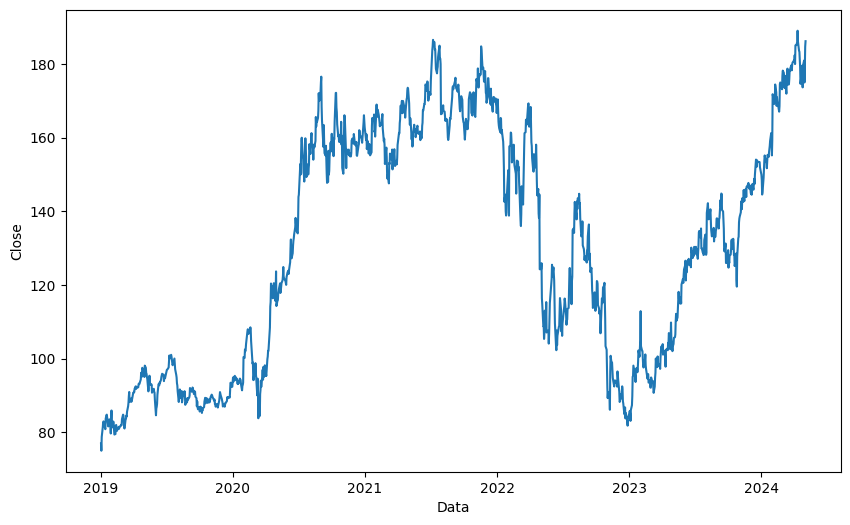

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

### Dane testowe

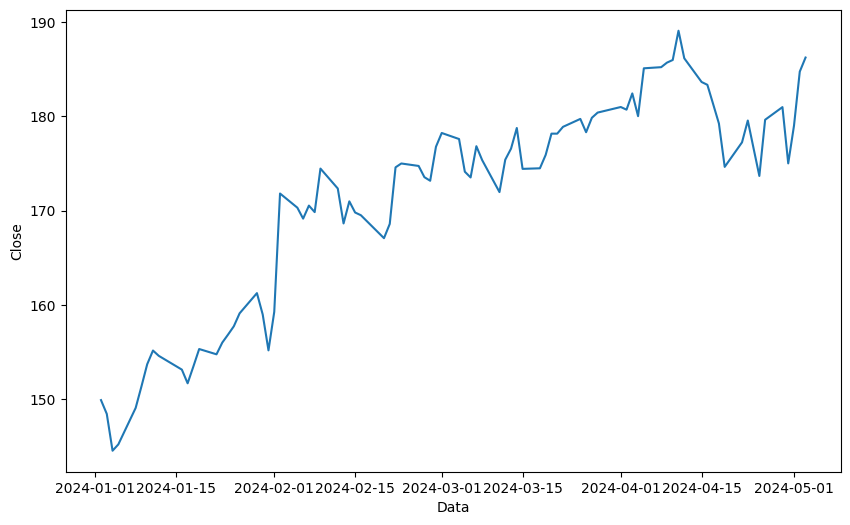

In [6]:
test_start = dt.datetime(2024,1,1) # (RRR-MM-DD)
test_end = dt.datetime(2024,5,6)

test_data = data.loc[(data.index >= test_start) & (data.index <= test_end)]
plt.figure(figsize=(10, 6))
plt.plot(test_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

## Dane treningowe


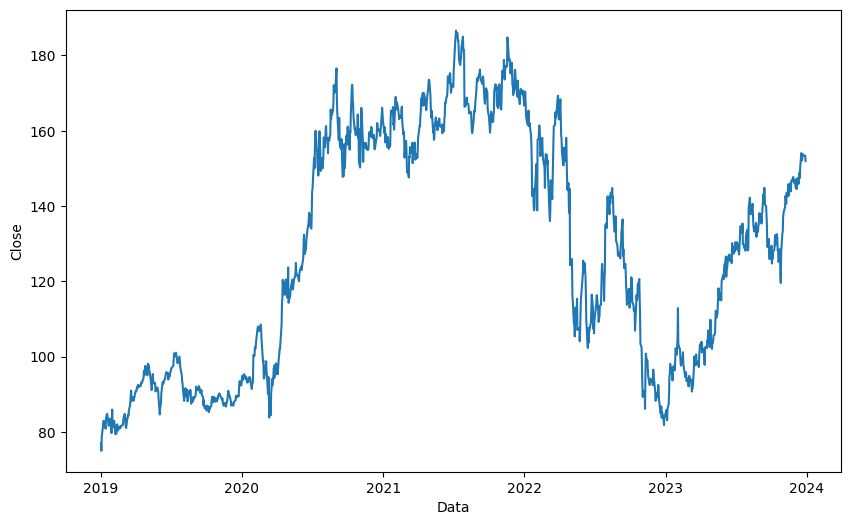

In [7]:
train_start = dt.datetime(2019,1,1)
train_end = dt.datetime(2024,1,1)

train_data = data.loc[(data.index >= train_start) & (data.index <= train_end)]
plt.figure(figsize=(10, 6))
plt.plot(train_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

### Zwroty
Używam zwrotów logarytmicznych, ponieważ są bardziej odporne na wahanai i wartości odstające.

In [28]:
data['returns'] = data['Close'].to_log_returns()
data = data.dropna()

# Testy biblioteki 'ffn'

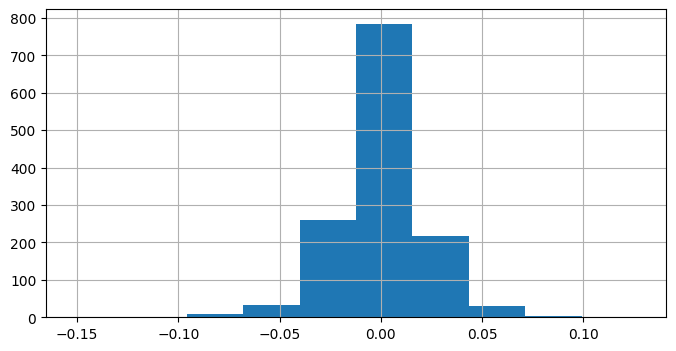

In [29]:
ax = data['returns'].hist(figsize=(8, 4))

#### Porównanie z indeksem NASDAQ (^IXIC)

In [30]:
df = ffn.get('^IXIC:Close, AMZN:Close', start=train_start, end=train_end)

[*********************100%***********************]  1 of 1 completed


In [31]:
returns = df.to_log_returns().dropna()
print(returns.head())

            ixicclose  amznclose
Date                            
2019-01-03  -0.030840  -0.025566
2019-01-04   0.041720   0.048851
2019-01-07   0.012477   0.033777
2019-01-08   0.010718   0.016476
2019-01-09   0.008673   0.001713


In [32]:
df.head()

,ixicclose,amznclose
Date,,
2019-01-02,6665.939941,76.956497
2019-01-03,6463.500000,75.014000
2019-01-04,6738.859863,78.769501
2019-01-07,6823.470215,81.475502
2019-01-08,6897.000000,82.829002


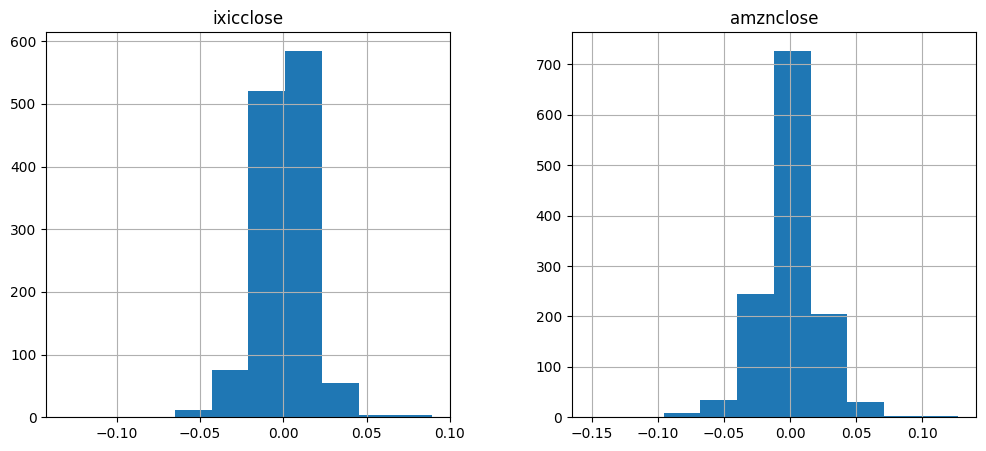

In [33]:
ax2 = returns.hist(figsize=(12, 5))

In [34]:
returns.corr().as_format('.2f')

,ixicclose,amznclose
ixicclose,1.00,0.76
amznclose,0.76,1.00


<Axes: xlabel='Date'>

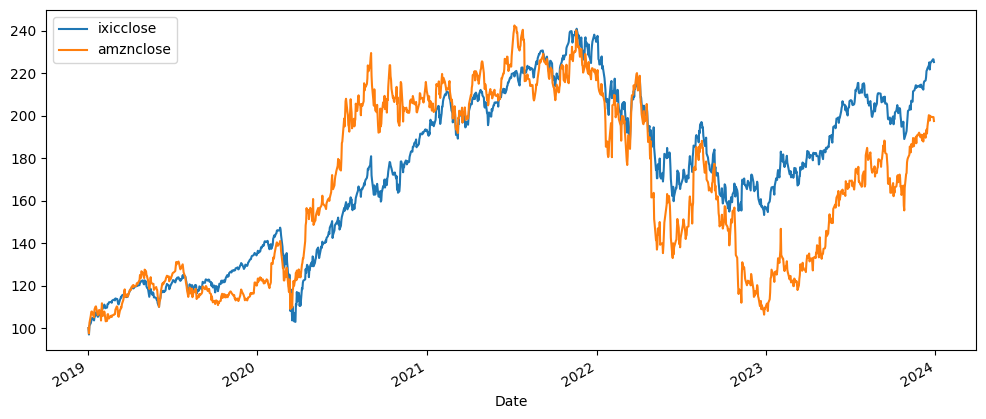

In [35]:
df.rebase().plot(figsize=(12,5))

Widać wysoką korelację pomiędzy szeregami

In [36]:
perf = df.calc_stats()
perf.display()

Stat                 ixicclose    amznclose
-------------------  -----------  -----------
Start                2019-01-02   2019-01-02
End                  2023-12-29   2023-12-29
Risk-free rate       0.00%        0.00%

Total Return         125.19%      97.44%
Daily Sharpe         0.77         0.56
Daily Sortino        1.22         0.95
CAGR                 17.67%       14.61%
Max Drawdown         -36.40%      -56.15%
Calmar Ratio         0.49         0.26

MTD                  5.52%        4.00%
3m                   13.56%       19.52%
6m                   10.45%       18.80%
YTD                  43.42%       80.88%
1Y                   43.26%       80.49%
3Y (ann.)            5.32%        -2.93%
5Y (ann.)            17.67%       14.61%
10Y (ann.)           -            -
Since Incep. (ann.)  17.67%       14.61%

Daily Sharpe         0.77         0.56
Daily Sortino        1.22         0.95
Daily Mean (ann.)    19.46%       19.84%
Daily Vol (ann.)     25.16%       35.22%
Daily Skew   

In [37]:
perf['ixicclose'].display_monthly_returns()

  Year    Jan    Feb     Mar     Apr    May    Jun    Jul    Aug     Sep    Oct    Nov    Dec     YTD
------  -----  -----  ------  ------  -----  -----  -----  -----  ------  -----  -----  -----  ------
  2019   9.24   3.44    2.61    4.74  -7.93   7.42   2.11  -2.6     0.46   3.66   4.5    3.54   34.6
  2020   1.99  -6.38  -10.12   15.45   6.75   5.99   6.82   9.59   -5.16  -2.29  11.8    5.65   43.64
  2021   1.42   0.93    0.41    5.4   -1.53   5.49   1.16   4      -5.31   7.27   0.25   0.69   21.39
  2022  -8.98  -3.43    3.41  -13.26  -2.05  -8.71  12.35  -4.64  -10.5    3.9    4.37  -8.73  -33.1
  2023  10.68  -1.11    6.69    0.04   5.8    6.59   4.05  -2.17   -5.81  -2.78  10.7    5.52   43.42


In [40]:
perf['amznclose'].display_monthly_returns()

  Year     Jan    Feb    Mar     Apr    May     Jun    Jul    Aug     Sep    Oct    Nov     Dec     YTD
------  ------  -----  -----  ------  -----  ------  -----  -----  ------  -----  -----  ------  ------
  2019   11.67  -4.59   8.59    8.19  -7.86    6.68  -1.42  -4.85   -2.27   2.35   1.36    2.61   20.06
  2020    8.71  -6.22   3.5    26.89  -1.28   12.96  14.71   9.05   -8.76  -3.58   4.34    2.81   76.26
  2021   -1.56  -3.53   0.04   12.07  -7.05    6.74  -3.27   4.3    -5.35   2.66   3.99   -4.93    2.38
  2022  -10.28   2.67   6.14  -23.75  -3.28  -11.65  27.06  -6.06  -10.86  -9.35  -5.76  -12.99  -49.62
  2023   22.77  -8.63   9.61    2.09  14.35    8.11   2.55   3.24   -7.89   4.7    9.77    4      80.88


In [41]:
# http://pmorissette.github.io/ffn/_modules/ffn/core.html#calc_perf_stats
perf['amznclose'].stats

start                    2019-01-02 00:00:00
end                      2023-12-29 00:00:00
rf                                       0.0
total_return                        0.974362
cagr                                0.146102
max_drawdown                       -0.561453
calmar                              0.260221
mtd                                 0.040044
three_month                         0.195249
six_month                           0.187959
ytd                                  0.80881
one_year                            0.804942
three_year                         -0.029284
five_year                           0.146102
ten_year                                 NaN
incep                               0.146102
daily_sharpe                        0.563181
daily_sortino                       0.946686
daily_mean                           0.19836
daily_vol                           0.352214
daily_skew                          0.090031
daily_kurt                          4.251938
best_day  

In [42]:
returns['Equity_amzn'] = returns['amznclose'].cumsum()+ 100
returns['Equity_amzn'].iloc[0] = 100

perm= ffn.core.PerformanceStats(returns['Equity_amzn'], rf=0.0)
perm.display()

Stats for Equity_amzn from 2019-01-03 00:00:00 - 2023-12-29 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
0.68%               0.39  0.14%   -0.82%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y      5y     10y    incep.
-----  -----  -----  -----  -----  ------  -----  -----  --------
0.04%  0.18%  0.17%  0.59%  0.59%  -0.03%  0.14%  -      0.14%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.39     0.36       0.21
mean    0.14%    0.12%      0.13%
vol     0.35%    0.32%      0.60%
skew    -0.12    0.07       -1.05
kurt    4.36     1.00       -0.27
best    0.13%    0.24%      0.59%
worst   -0.15%   -0.27%     -0.68%

Drawdowns:
max     avg       # days
------  ------  --------
-0.82%  -0.08%        62

Misc:
---------------  ------
avg. up month    0.07%
avg. down month  -0.07%
up year %        75.00%
12m up %         63.2

#### Sprawdzenie korelacji pomiędzy opóźnionymi szeregami

In [43]:
returns

,ixicclose,amznclose,Equity_amzn
Date,,,
2019-01-03,-0.030840,-0.025566,100.000000
2019-01-04,0.041720,0.048851,100.023286
2019-01-07,0.012477,0.033777,100.057062
2019-01-08,0.010718,0.016476,100.073538
2019-01-09,0.008673,0.001713,100.075251
...,...,...,...
2023-12-22,0.001943,-0.002734,100.689939
2023-12-26,0.005428,-0.000065,100.689874
2023-12-27,0.001631,-0.000456,100.689417


In [44]:
returns['lag_amzn'] = returns['amznclose'].shift(1)
returns

,ixicclose,amznclose,Equity_amzn,lag_amzn
Date,,,,
2019-01-03,-0.030840,-0.025566,100.000000,NaN
2019-01-04,0.041720,0.048851,100.023286,-0.025566
2019-01-07,0.012477,0.033777,100.057062,0.048851
2019-01-08,0.010718,0.016476,100.073538,0.033777
2019-01-09,0.008673,0.001713,100.075251,0.016476
...,...,...,...,...
2023-12-22,0.001943,-0.002734,100.689939,0.011243
2023-12-26,0.005428,-0.000065,100.689874,-0.002734
2023-12-27,0.001631,-0.000456,100.689417,-0.000065


In [45]:
returns['lag_ixic'] = returns['ixicclose'].shift(1)
returns

,ixicclose,amznclose,Equity_amzn,lag_amzn,lag_ixic
Date,,,,,
2019-01-03,-0.030840,-0.025566,100.000000,NaN,NaN
2019-01-04,0.041720,0.048851,100.023286,-0.025566,-0.030840
2019-01-07,0.012477,0.033777,100.057062,0.048851,0.041720
2019-01-08,0.010718,0.016476,100.073538,0.033777,0.012477
2019-01-09,0.008673,0.001713,100.075251,0.016476,0.010718
...,...,...,...,...,...
2023-12-22,0.001943,-0.002734,100.689939,0.011243,0.012503
2023-12-26,0.005428,-0.000065,100.689874,-0.002734,0.001943
2023-12-27,0.001631,-0.000456,100.689417,-0.000065,0.005428


In [46]:
lag_msft_corr = returns[['ixicclose', 'lag_amzn']]
lag_msft_corr=lag_msft_corr.dropna()
lag_msft_corr.corr().as_format('.2f')

,ixicclose,lag_amzn
ixicclose,1.00,-0.07
lag_amzn,-0.07,1.00


In [ ]:
lag_msft_corr

In [47]:
lag_ixi_corr = returns[['amznclose', 'lag_ixic']]
lag_ixi_corr.dropna()
lag_ixi_corr.corr().as_format('.2f')

,amznclose,lag_ixic
amznclose,1.00,-0.09
lag_ixic,-0.09,1.00


### Sprawdzanie przyczynowości


In [48]:
my_data = pd.DataFrame({'NASDAQ': returns['ixicclose'], 'AMZN': returns['amznclose']})

# Wybór modelu VAR
model = VAR(my_data)
results = model.fit(maxlags=1, ic='aic')

print(results.summary())

# Test Ljung-Boxa
ljung_box_gold = acorr_ljungbox(results.resid['NASDAQ'])
print(f"Ljung-Box test for NASDAQ: {ljung_box_gold}")

ljung_box_silver = acorr_ljungbox(results.resid['AMZN'])
print(f"Ljung-Box test for AMZN: {ljung_box_silver}")

# Test stabilności
stability_test = results.test_causality('NASDAQ', 'AMZN', kind='f')
print(stability_test.summary())

stability_test_2 = results.test_causality('AMZN', 'NASDAQ', kind='f')
print(stability_test_2.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 20, May, 2024
Time:                     08:36:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.7800
Nobs:                     1256.00    HQIC:                  -16.7953
Log likelihood:           6994.89    FPE:                5.03351e-08
AIC:                     -16.8046    Det(Omega_mle):     5.00955e-08
--------------------------------------------------------------------
Results for equation NASDAQ
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000788         0.000442            1.784           0.074
L1.NASDAQ        -0.260339         0.042980           -6.057           0.000
L1.AMZN           0.095471         0.030821            3.098           0.00

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


L1.NASDAQ - NASDAQ = -0.101991 -> jednostkowe opóźnienie w NASDAQ prowadzi do zmniejszenia NASDAQ o 0.101991 jednostki.

W resztach modelu występuje autokorelacja.

**Test przyczynowości Grangera:**
- MSFT nie wypływa na NASDAQ (p-value = 0.288)
- NASDAQ wpływa na MSFT (p-value  =0.021)

Przeszłe wartości NASDAQ są przydatne do przewidywania przyszłych wartości MSFT. 

## MFI - Money Flow Index

  * The Money Flow Index [MFI](https://www.investopedia.com/terms/m/mfi.asp) is a technical indicator that generates overbought or oversold signals using both prices and volume data.
  * An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold,1 although levels of 90 and 10 are also used as thresholds.
  * A divergence between the indicator and price is noteworthy. For example, if the indicator is rising while the price is falling or flat, the price could start rising.
 
 
**BUY: MFI < 20**

**SELL: MFI > 80**
  
Money Flow Index:


$\text{Money Flow Index} = 100 - \frac{{100}}{{1 + \text{Money Flow Ratio}}}$

Where:

Money Flow Ratio:


$\text{Money Flow Ratio} = \frac{{\text{14 Period Positive Money Flow}}}{{\text{14 Period Negative Money Flow}}}$


And:

Raw Money Flow:


$\text{Raw Money Flow} = \text{Typical Price} \times \text{Volume}$

Typical Price:


$\text{Typical Price} = \frac{{\text{High} + \text{Low} + \text{Close}}}{3}$



In [49]:
def calculate_mfi(df, period=14):
    
    """
    Calculate the Money Flow Index (MFI) for a given DataFrame
    
    Parameters:
        df (DataFrame): DataFrame containing 'High', 'Low', 'Close', and 'Volume' columns
        period (int, optional): The number of periods to consider for MFI calculation. Default is 14
    
    Returns:
        Series: Money Flow Index (MFI) values
    """
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']
    
    typical_price = (high + low + close) / 3
    raw_money_flow = typical_price * volume
    
    positive_flow = raw_money_flow * (typical_price > typical_price.shift(1))
    negative_flow = raw_money_flow * (typical_price < typical_price.shift(1))
    
    positive_flow_sum = positive_flow.rolling(window=period, min_periods=1).sum()
    negative_flow_sum = negative_flow.rolling(window=period, min_periods=1).sum()
    
    money_flow_ratio = positive_flow_sum / negative_flow_sum
    money_flow_index = 100 - (100 / (1 + money_flow_ratio))
    
    return money_flow_index


# calculate MFI
data['MFI'] = calculate_mfi(data)


In [50]:
data = data.dropna()

## Stworzenie sygnałów kupna/sprzedaży

In [51]:
def decision_mfi(df):
    df['dec_mfi'] = 0  

    df.loc[df['MFI'] <= 20, 'dec_mfi'] = 1
    df.loc[df['MFI'] >= 80, 'dec_mfi'] = -1

    return df

In [52]:
decision_mfi(data)
data['dec_mfi'].value_counts()

dec_mfi
 0    1298
-1      22
 1      21
Name: count, dtype: int64

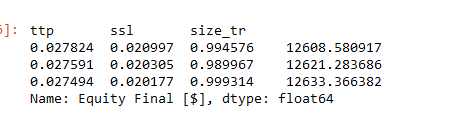

In [53]:
class CustomStrategy(SignalStrategy):
    
    ssl = 0.046
    ttp = 0.054
    size_tr = 0.9
    def init(self):
        
        super().init()
        self.rsi = self.I(lambda x: data['dec_mfi'], 'mfi')

    def next(self):
        
        close = self.data.Close
        signal = self.rsi
        #prev_signal = self.rsi[-1]
        
        upper_tp = close*(1+self.ttp) 
        upper_sl = close*(1+self.ssl) 
        lower_sl = close*(1-self.ssl)   
        lower_tp = close*(1-self.ttp)
        
        #size_transaction = 0.85
        
        #if not signal == prev_signal:
        if signal == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl = upper_sl, tp=lower_tp)
                
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, 
              trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

#optymalizacja parametrow
stats_skopt, heatmap, optimize_result = bt.optimize(ttp=[0.01, 0.1],
           ssl=[0.01, 0.1],
           size_tr=[0.4, 1], 
           maximize='Equity Final [$]',
           method='skopt',
           max_tries=1000,
           random_state=10,
           return_heatmap=True,
           return_optimization=True)
heatmap.sort_values().iloc[-3:]

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.053247  0.095097  0.997926    17554.396596
0.053358  0.095068  0.994563    17554.789674
0.053371  0.093580  0.992292    17566.038655
Name: Equity Final [$], dtype: float64

In [64]:
stats

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   87.209302
Equity Final [$]                 10448.533276
Equity Peak [$]                  10790.917246
Return [%]                           4.485333
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                   13.719921
Volatility (Ann.) [%]               18.629728
Sharpe Ratio                         0.736453
Sortino Ratio                        1.343322
Calmar Ratio                         2.353332
Max. Drawdown [%]                   -5.829999
Avg. Drawdown [%]                   -2.710049
Max. Drawdown Duration       37 days 00:00:00
Avg. Drawdown Duration       16 days 00:00:00
# Trades                                   59
Win Rate [%]                        47.457627
Best Trade [%]                       5.512932
Worst Trade [%]                     -2.594056
Avg. Trade [%]                    

In [54]:
stats_skopt

Start                     2019-01-07 00:00:00
End                       2024-05-03 00:00:00
Duration                   1943 days 00:00:00
Exposure Time [%]                   19.686801
Equity Final [$]                 17566.038655
Equity Peak [$]                  17785.772119
Return [%]                          75.660387
Buy & Hold Return [%]              128.547235
Return (Ann.) [%]                   11.167791
Volatility (Ann.) [%]               15.695674
Sharpe Ratio                          0.71152
Sortino Ratio                        1.179366
Calmar Ratio                         0.629632
Max. Drawdown [%]                  -17.737016
Avg. Drawdown [%]                   -4.538846
Max. Drawdown Duration      739 days 00:00:00
Avg. Drawdown Duration       61 days 00:00:00
# Trades                                   19
Win Rate [%]                        84.210526
Best Trade [%]                       7.882035
Worst Trade [%]                     -10.50427
Avg. Trade [%]                    

## Podział na dane testowe i treningowe
#### Przygotowanie danych pod deep learning

In [55]:
# Wybór danych testowych i treningowych
train_data = data[(data.index >= train_start) & (data.index <= train_end)]
test_data = data[(data.index >= test_start) & (data.index <= test_end)]

# Przygotowanie danych
prices_train = train_data["Close"].values.reshape(-1, 1)  # konwersja do tablicy numpy
prices_test = test_data["Close"].values.reshape(-1, 1)

# Przeskalowanie do zakresu [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices_train = scaler.fit_transform(prices_train)
scaled_prices_test = scaler.transform(prices_test)

# Tworzenie sekwencji danych dla modelu LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Określenie długości sekwencji (liczba kroków wstecznych)
sequence_length = 10

# Utworzenie sekwencji danych treningowych i testowych
X_train, y_train = create_sequences(scaled_prices_train, sequence_length)
X_test, y_test = create_sequences(scaled_prices_test, sequence_length)

print("Rozmiar danych treningowych:", X_train.shape, y_train.shape)
print("Rozmiar danych testowych:", X_test.shape, y_test.shape)

Rozmiar danych treningowych: (1245, 10, 1) (1245, 1)
Rozmiar danych testowych: (76, 10, 1) (76, 1)


## LSTM

In [56]:
# Model LSTM z hiperparametryzacją
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Tworzenie
input_shape = (X_train.shape[1], X_train.shape[2])  # Kształt danych wejściowych dla modelu LSTM
lstm_model = create_lstm_model(input_shape)

# Trenowanie
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predykcja cen dla danych testowych
predicted_prices = lstm_model.predict(X_test)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.1347 - val_loss: 0.0038
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.5281e-04 - val_loss: 6.3330e-04
Epoch 68/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9451e-04 - val_loss: 6.0079e-04
Epoch 69/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.7544e-04 - val_loss: 5.9535e-04
Epoch 70/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.4520e-04 - val_loss: 5.8931e-04
Epoch 71/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4548e-04 - val_loss: 5.7535e-04
Epoch 72/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9383e-04 - val_loss: 5.8508e-04
Epoch 73/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5958e-04 - val_loss: 6.4236e-04
Epoch 74/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4730e-04 - val_loss: 5.8834e-04
Epoch 75/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6274e-04 - val_loss: 5.9422e-04
Epoch 76/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2380e-04 - val_loss: 6.2391e-04
Epoch 77/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.

In [57]:
mse = mean_squared_error(y_test, predicted_prices)
print("Mean Squared Error (MSE) na danych testowych:", mse.round(5))

Mean Squared Error (MSE) na danych testowych: 0.00077


In [58]:
predicted_prices_unscaled = scaler.inverse_transform(predicted_prices)

In [59]:
# Dodanie przewidywanych cen do testowych danych
test_data['Predicted_Close'] = np.nan
test_data['Predicted_Close'].iloc[sequence_length:] = predicted_prices_unscaled.flatten()

# Tworzenie sygnałów
test_data['Signal'] = 0
test_data['Signal'][sequence_length:] = np.where(test_data['Predicted_Close'][sequence_length:] > test_data['Close'][sequence_length:], 1, -1)


In [60]:
# Przygotowanie danych do backtestingu

data_for_backtest = pd.DataFrame(index=test_data.index)
data_for_backtest['Open'] = test_data['Open']
data_for_backtest['High'] = test_data['High']
data_for_backtest['Low'] = test_data['Low']
data_for_backtest['Close'] = test_data['Close']
data_for_backtest['Predicted'] = test_data['Predicted_Close']

In [61]:
class LSTMStrategy(Strategy):
    def init(self):
        self.predicted = self.data.Predicted

    def next(self):
        idx = len(self.data) - 1  # Pobranie aktualnego indeksu
        if self.predicted[idx] > self.data.Close[-1]:
            self.buy()
        elif self.predicted[idx] < self.data.Close[-1]:
            self.sell()



In [62]:
bt = Backtest(data_for_backtest, LSTMStrategy, cash=10000, commission=.002)
stats = bt.run()
bt.plot()
stats

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   87.209302
Equity Final [$]                 12230.831199
Equity Peak [$]                   12338.33982
Return [%]                          22.308312
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                   80.412381
Volatility (Ann.) [%]               46.853198
Sharpe Ratio                         1.716262
Sortino Ratio                        5.831782
Calmar Ratio                         9.924527
Max. Drawdown [%]                   -8.102389
Avg. Drawdown [%]                    -2.46819
Max. Drawdown Duration       22 days 00:00:00
Avg. Drawdown Duration        8 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      22.155375
Worst Trade [%]                     22.155375
Avg. Trade [%]                    

In [63]:

class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.014294
    ttp = 0.029230
    size_tr = 0.970131

    def init(self):
        super().init()
        self.signal = self.I(lambda x: test_data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

# Przeprowadzenie backtestu
bt = Backtest(test_data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# Optymalizacja parametrów
stats_skopt, heatmap, optimize_result = bt.optimize(
    ttp=[0.01, 0.1],
    ssl=[0.01, 0.1],
    size_tr=[0.4, 1], 
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=1000,
    random_state=10,
    return_heatmap=True,
    return_optimization=True
)
heatmap.sort_values().iloc[-3:]


Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   87.209302
Equity Final [$]                 10448.533276
Equity Peak [$]                  10790.917246
Return [%]                           4.485333
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                   13.719921
Volatility (Ann.) [%]               18.629728
Sharpe Ratio                         0.736453
Sortino Ratio                        1.343322
Calmar Ratio                         2.353332
Max. Drawdown [%]                   -5.829999
Avg. Drawdown [%]                   -2.710049
Max. Drawdown Duration       37 days 00:00:00
Avg. Drawdown Duration       16 days 00:00:00
# Trades                                   59
Win Rate [%]                        47.457627
Best Trade [%]                       5.512932
Worst Trade [%]                     -2.594056
Avg. Trade [%]                    

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.023208  0.039081  0.983056    14162.542102
0.023308  0.039677  0.989044    14723.167710
0.023364  0.038662  0.990048    14781.344851
Name: Equity Final [$], dtype: float64

In [65]:
class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.038662
    ttp = 0.023364
    size_tr = 0.990048

    def init(self):
        super().init()
        self.signal = self.I(lambda x: test_data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

# Przeprowadzenie backtestu
bt = Backtest(test_data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

Start                     2024-01-02 00:00:00
End                       2024-05-03 00:00:00
Duration                    122 days 00:00:00
Exposure Time [%]                   87.209302
Equity Final [$]                 14781.287253
Equity Peak [$]                  14781.287253
Return [%]                          47.812873
Buy & Hold Return [%]                24.19797
Return (Ann.) [%]                  214.265264
Volatility (Ann.) [%]               66.950759
Sharpe Ratio                         3.200341
Sortino Ratio                       24.355154
Calmar Ratio                        57.905003
Max. Drawdown [%]                   -3.700289
Avg. Drawdown [%]                   -1.370159
Max. Drawdown Duration       10 days 00:00:00
Avg. Drawdown Duration        5 days 00:00:00
# Trades                                   32
Win Rate [%]                           71.875
Best Trade [%]                       7.549234
Worst Trade [%]                      -4.57342
Avg. Trade [%]                    